# Graffiti

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# example of using a pre-trained model as a classifier
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from subprocess import check_output
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
x = np.load('/content/drive/MyDrive/final/xres.npy')
y = np.load('/content/drive/MyDrive/final/yres.npy')


In [ ]:
y_multiclass = np.argmax(y, axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_multiclass, test_size=0.2, random_state=42)

In [ ]:
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [ ]:
from tensorflow import convert_to_tensor

x_train = convert_to_tensor(x_train)
y_train = convert_to_tensor(y_train)

x_test = convert_to_tensor(x_test)
y_test = convert_to_tensor(y_test)

In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.regularizers import l2
# load model without classifier layers

# model = EfficientNetB3(include_top=False, input_shape=(200, 200, 3), pooling='max')
model = ResNet101V2(include_top=False, input_shape=(400, 400, 3), pooling='max')

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
# class1 = Dense(1024, activation='relu', kernel_regularizer=l2(0.5))(flat1)
# drop1 = Dropout(0.4)(class1)
output = Dense(1, activation='softmax')(class1)

model = Model(inputs=model.inputs, outputs=output)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 406, 406, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 200, 200, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 202, 202, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy


for layer in model.layers[:-17]:
    layer.trainable = False

optimizer = Adam(learning_rate=0.001, beta_1=0.9)
model.compile(optimizer=optimizer, loss="CategoricalCrossentropy", metrics=['accuracy'])


In [ ]:
from sklearn.model_selection import KFold
from tensorflow import gather

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

kf = KFold(n_splits=5, shuffle=True, random_state=2)
for train_index, val_index in kf.split(x_train):
    X_train, X_val = gather(x_train, train_index), gather(x_train, val_index)
    Y_train, Y_val = gather(y_train, train_index), gather(y_train, val_index)

    # Train the model
    history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, Y_val)
    print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}\n')

    # store training and validation loss
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])
    train_accuracies.extend(history.history['accuracy'])
    val_accuracies.extend(history.history['val_accuracy'])


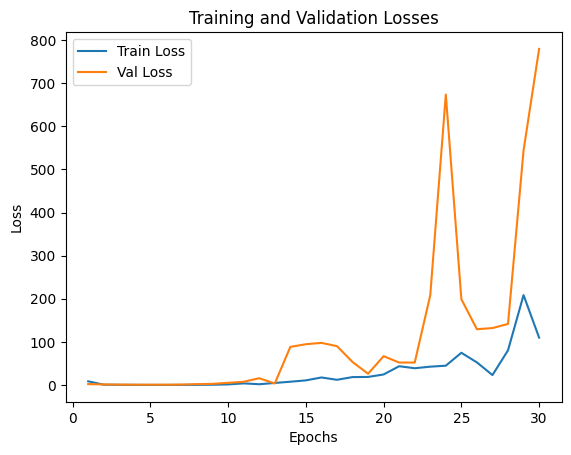

In [ ]:
# epochs = len(train_losses) // 5  # assuming same number of epochs for each fold
epochs = 50
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.savefig('loss_accuracy_plot_vgg.png')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/final/kfoldres.keras")
# from tensorflow.keras.models import load_model
# model = load_model('kfold.keras')

In [ ]:
y_pred = model.predict(x_test)

13/13 [==============================] - 3s 96ms/step


In [ ]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 1s 102ms/step - loss: 589.7856 - accuracy: 0.7019


[589.78564453125, 0.7019230723381042]

In [ ]:
filename1 = "/content/drive/MyDrive/final/imgs/blank1.jpg" # correct
filename2 = "/content/drive/MyDrive/final/imgs/blank2.jpg" # correct
filename3 = "/content/drive/MyDrive/final/imgs/samMaster.jpg" # tag
filename4 = "/content/drive/MyDrive/final/imgs/sovietKiss.jpeg" # tag
filename5 = "/content/drive/MyDrive/final/imgs/tags.jpeg" # correct
filename6 = "/content/drive/MyDrive/final/imgs/throwup.jpeg" # masterpiece
filename7 = "/content/drive/MyDrive/final/imgs/cphmaster.jpeg" # tags

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

# load an image from file
image = load_img(filename7)
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model

# predict the probability across all output classes
model.predict(image)